**Table of contents**<a id='toc0_'></a>    
1.1. [Load Data](#toc1_1_)    
1.2. [Data Visualization](#toc1_2_)    
1.3. [Assumptions Check](#toc1_3_)    
1.3.1. [Dependency check](#toc1_3_1_)    
1.3.2. [Normality & Homoscedasticity Assumptions Check](#toc1_3_2_)    
1.4. [Analyse of Variances](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as stats
import seaborn as sns

# force reload modules
%load_ext autoreload
%autoreload

## 1.1. <a id='toc1_1_'></a>[Load Data](#toc0_)

In [2]:
df = pd.read_excel("data/data.xlsx")
df.head()

,Date,LC2A,MP2,MP1,MC
0,22/10/2025 18:00,721.0,870.75,845.12,850.2
1,22/10/2025 20:00,650.0,760.20,848.10,889.8
2,22/10/2025 22:30,644.0,638.40,749.00,682.3
3,23/10/2025 01:00,636.0,552.70,741.00,658.2
4,23/10/2025 04:00,649.0,607.42,755.40,670.2


In [3]:
cols = ["Date", "LC2A", "MP2", "MP1", "MC"]

data = (df[cols]
    .melt(id_vars="Date", var_name="group", value_name="value")
    .dropna()
    .sort_values(by="Date")
    .drop(columns=["Date", "group"])
)
data.head(6)

,value
0,721.00
69,850.20
46,845.12
23,870.75
70,889.80
24,760.20


## Basic Summary Statistics

In [4]:
X = data.values.flatten()
n = 1_000
X = np.random.normal(0, 1, n)
X= np.random.lognormal (1, 1, n)
X = X.flatten()

In [5]:
data = pd.Series(X)
stats_summary:pd.DataFrame = data.describe()
# add skewness and kurtisis to stats_summary
stats_summary.loc["skewness"] = data.skew()
stats_summary.loc["kurtosis"] = data.kurtosis()
stats_summary.round(3)

count       1000.000
mean           4.215
std            4.672
min            0.101
25%            1.257
50%            2.671
75%            5.287
max           53.342
skewness       3.261
kurtosis      19.225
dtype: float64

## 1.2. <a id='toc1_2_'></a>[Data Visualization](#toc0_)

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import medcouple


def adaptive_boxplot(data, adjusted=False, ax=None):
    """
    Creates an Adjusted Boxplot for skewed distributions (Hubert & Vandervieren, 2008).
    """
    import scipy.stats as stats
    if ax is None:
        fig, ax = plt.subplots()

    X = np.array(data)
    X = X[~np.isnan(X)]  # Remove NaNs
    

    import seaborn as sns
    if not adjusted or (float(abs(stats.skew(X))) < 1 and float(abs(stats.kurtosis(X))) < 1):
        mc = 0
    else:
        mc = medcouple(X)
        
    q1, q3 = np.percentile(X, [25, 75])
    iqr = q3 - q1

    # Calculate whiskers based on medcouple sign
    if mc >= 0:
        lower_whisker = q1 - 1.5 * np.exp(-4 * mc) * iqr
        upper_whisker = q3 + 1.5 * np.exp(3.5 * mc) * iqr
    else:
        lower_whisker = q1 - 1.5 * np.exp(-3.5 * mc) * iqr
        upper_whisker = q3 + 1.5 * np.exp(4 * mc) * iqr

    # Identify outliers
    outliers = X[(X < lower_whisker) | (X > upper_whisker)]

    # Plotting
    # We use a standard boxplot but manually override the whiskers/fliers if needed,
    # or simply plot the components manually for clarity.
    # Here is a manual construction to ensure the adjusted whiskers are respected.

    # Filter X within whiskers for the box and whiskers plot
    mask_within = (X >= lower_whisker) & (X <= upper_whisker)
    adjacent_values = X[mask_within]

    if len(adjacent_values) > 0:
        whisker_min = np.min(adjacent_values)
        whisker_max = np.max(adjacent_values)
    else:
        whisker_min = q1
        whisker_max = q3

    stats = [
        {
            "med": np.median(X),
            "mean": np.mean(X),
            "q1": q1,
            "q3": q3,
            "whislo": whisker_min,
            "whishi": whisker_max,
            "fliers": outliers,
            "label": "",
        }
    ]

    ax.bxp(stats, showfliers=True, orientation="horizontal", showmeans=True, widths=0.4, flierprops={"markersize": 4})
    if mc != 0:
        ax.set_xlabel(f"Adjusted Boxplot (medcouple={mc:.3f})", fontsize=10)
    return ax


[]

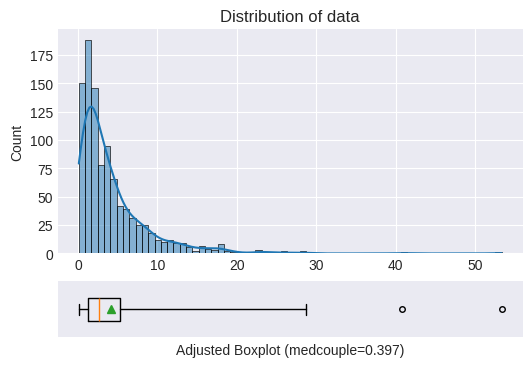

In [90]:
plt.style.use("seaborn-v0_8-dark")
fig, ax = plt.subplots(2, figsize=(6,4), height_ratios=(0.8,0.2))
sns.histplot(X, kde=True, bins='auto', ax=ax[0])

ax[0].set_title("Distribution of data")
ax[0].grid(True)

# sns.boxplot(X, orient='h', width=0.5, showmeans=True, fill=True, ax=ax[1], boxprops=dict(alpha=0.5), flierprops={"markersize": 4})
adaptive_boxplot(X, ax=ax[1], adjusted=True)
ax[1].set_xticks([])
# plt.tight_layout()

## 1.3. <a id='toc1_3_'></a>[Assumptions Check](#toc0_)

In [91]:
from assumptions import check_multimodality, check_normality, recommand_normality_test
from robustness import recommand_outliers_test


In [92]:
%autoreload

is_unimodal, k_modes = check_multimodality(X)
is_unimodal, k_modes


======== GAUSSIAN MIXTURE MODEL (BIC COMPARISON) ========
--------------------------------------------------
Components      BIC                    AIC
--------------------------------------------------
1            5933.95                5924.13               
2            5171.80                5147.26               
3            5029.08                4989.82               
4            4920.06                4866.07               
5            4914.55 ← BEST         4845.85 ← BEST        
--------------------------------------------------
✗ STRONG evidence of MULTIMODALITY (5 components)



(False, 5)

### 1.3.2. <a id='toc1_3_2_'></a>[Normality](#toc0_)

In [93]:
normality_result = pg.normality(data=X, method='shapiro')
is_all_normal = normality_result.all(bool_only=True).iat[0]
normality_result

NameError: name 'pg' is not defined